In [227]:
import numpy as np
import pandas as pd
import seaborn
import re
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine, euclidean

In [228]:
def getWords(text, stopwords):
    splitted_text = text.split()
    new_splitted_text = []
    for item in splitted_text:
        if len(item) == 1:
            item = item.lower()
        new_splitted_text.append(item)
    new_text = " ".join(new_splitted_text)
    new_text = re.sub("\.", " ", new_text)
    new_text = re.sub("_", "", new_text)
    new_text = re.sub("(?<= [A-Z]{1}) +((?=[A-Z] )|(?=[A-Z]$))", "", new_text)
    all_words = re.compile('\w+').findall(new_text)
    return [words.lower() for words in all_words if len(words)>1 and words.lower() not in stopwords]

def get_word_score(model, word):
    try:
        score = model.wv[word]
    except:
        score = np.repeat(np.nan, repeats=VECTOR_DIM)
    return score

def get_title_score(model, title):
    title_parsed = getWords(title, stopwords)
    mean_score = np.nanmean([get_word_score(model, i) for i in title_parsed], axis = 0) #nanmean to jak na.rm=TRUE w R
    return mean_score

In [229]:
stopwords = pd.read_csv("stopwords.csv").as_matrix()
stopwords.resize(stopwords.shape[0])

In [230]:
data = pd.read_csv("titles_books.csv")

In [231]:
titles = [getWords(title, stopwords) for title in data.title]

In [232]:
test_data = pd.read_csv("test_data.csv")

In [233]:
test_data.head()

,Unnamed: 0,title,author,book_title
0,5212624405,WIEDŹMIN. OSTATNIE ŻYCZENIE - Andrzej Sapkowsk...,Sapkowski,Ostatnie Życzenie
1,5566813618,Ostatnie życzenie - Andrzej Sapkowski wiedźmin,Sapkowski,Ostatnie Życzenie
2,5697678702,Ostatnie życzenie + Miecz przeznaczenia Sapkowski,Sapkowski,Ostatnie Życzenie
3,5822470003,ksiazka-OSTATNIE ŻYCZENIE WIEDŹMIN - Sapkowski,Sapkowski,Ostatnie Życzenie
4,6629328672,SAPKOWSKI Wiedźmin 1 OSTATNIE ŻYCZENIE,Sapkowski,Ostatnie Życzenie


In [234]:
sample_authors = np.random.choice(np.unique(test_data.author.values), 4, False)
sample_test_data = []
for i in sample_authors:
    sample_author_books = test_data[test_data.author == i]
    chosen_books = np.random.choice(np.unique(sample_author_books.book_title.values), 2, False)
    for j in chosen_books:
        chosen_titles = test_data[test_data.book_title == j]
        sample_test_data.append(np.random.choice(chosen_titles.title, 4, False))
sample_test_data = np.hstack(sample_test_data)
sample_test_data

array(['Taniec ze smokami MK. tom 1-2 Martin Pakiet',
       'TANIEC ZE SMOKAMI. CZ.1 George R.R. Martin',
       'TANIEC ZE SMOKAMI CZ. 2 George R.R. Martin',
       'UCZTA DLA WRON + TANIEC ZE SMOKAMI _ R.R. Martin',
       'NAWAŁNICA MIECZY KREW I ZŁOTO G.R.R.MARTIN',
       'NAWAŁNICA MIECZY II KREW I ZŁOTO George R.R.Martin',
       'Martin NAWAŁNICA MIECZY Krew i złoto   a6',
       'MARTIN PIEŚŃ LODU I OGNIA TOM 3 NAWAŁNICA MIECZY 1',
       'Assassin`s Creed. Renesans - Oliver Bowden',
       'Bowden Assassins Creed x5 Renesans Bractwo Poje...',
       'Assassins Creed T1 Renesans - Oliver Bowden',
       'Assassin`s Creed Renesans Oliver Bowden Fantasy',
       'ASSASSIN`S CREED OBJAWIENIA OLIVER BOWDEN NOWA',
       'Assassins Creed Objawienie Oliver Bowden tom 4',
       'Assassin`s Creed: Objawienia /Oliver Bowden',
       "Assassin's Creed: Objawienia Bowden - avalonpl",
       'WŁADCA PIERŚCIENI DWIE WIEŻE DRUŻYNA - TOLKIEN 3T',
       'Władca Pierścieni Drużyna Pier... -

In [235]:
VECTOR_DIM = 100

In [236]:
model = Word2Vec(titles, size=VECTOR_DIM, min_count=0)

In [237]:
vectorized_sample_titles = np.array([get_title_score(model, title) for title in sample_test_data])

In [238]:
def euklidean_distance(u, v):
    return np.sqrt(np.sum((u-v)**2))

def cosine_distance(u, v):
    return cosine(u, v)

In [239]:
n = vectorized_sample_titles.shape[0]
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        similarity_matrix[i,j] = euklidean_distance(vectorized_sample_titles[i], vectorized_sample_titles[j])

In [240]:
similarity_matrix = pd.DataFrame(similarity_matrix)
similarity_matrix.columns = np.arange(similarity_matrix.shape[0]) + 1
row_names = sample_test_data.copy()
for i in range(len(row_names)):
    row_names[i] = str(i+1) + ". " + row_names[i]
similarity_matrix.index = row_names

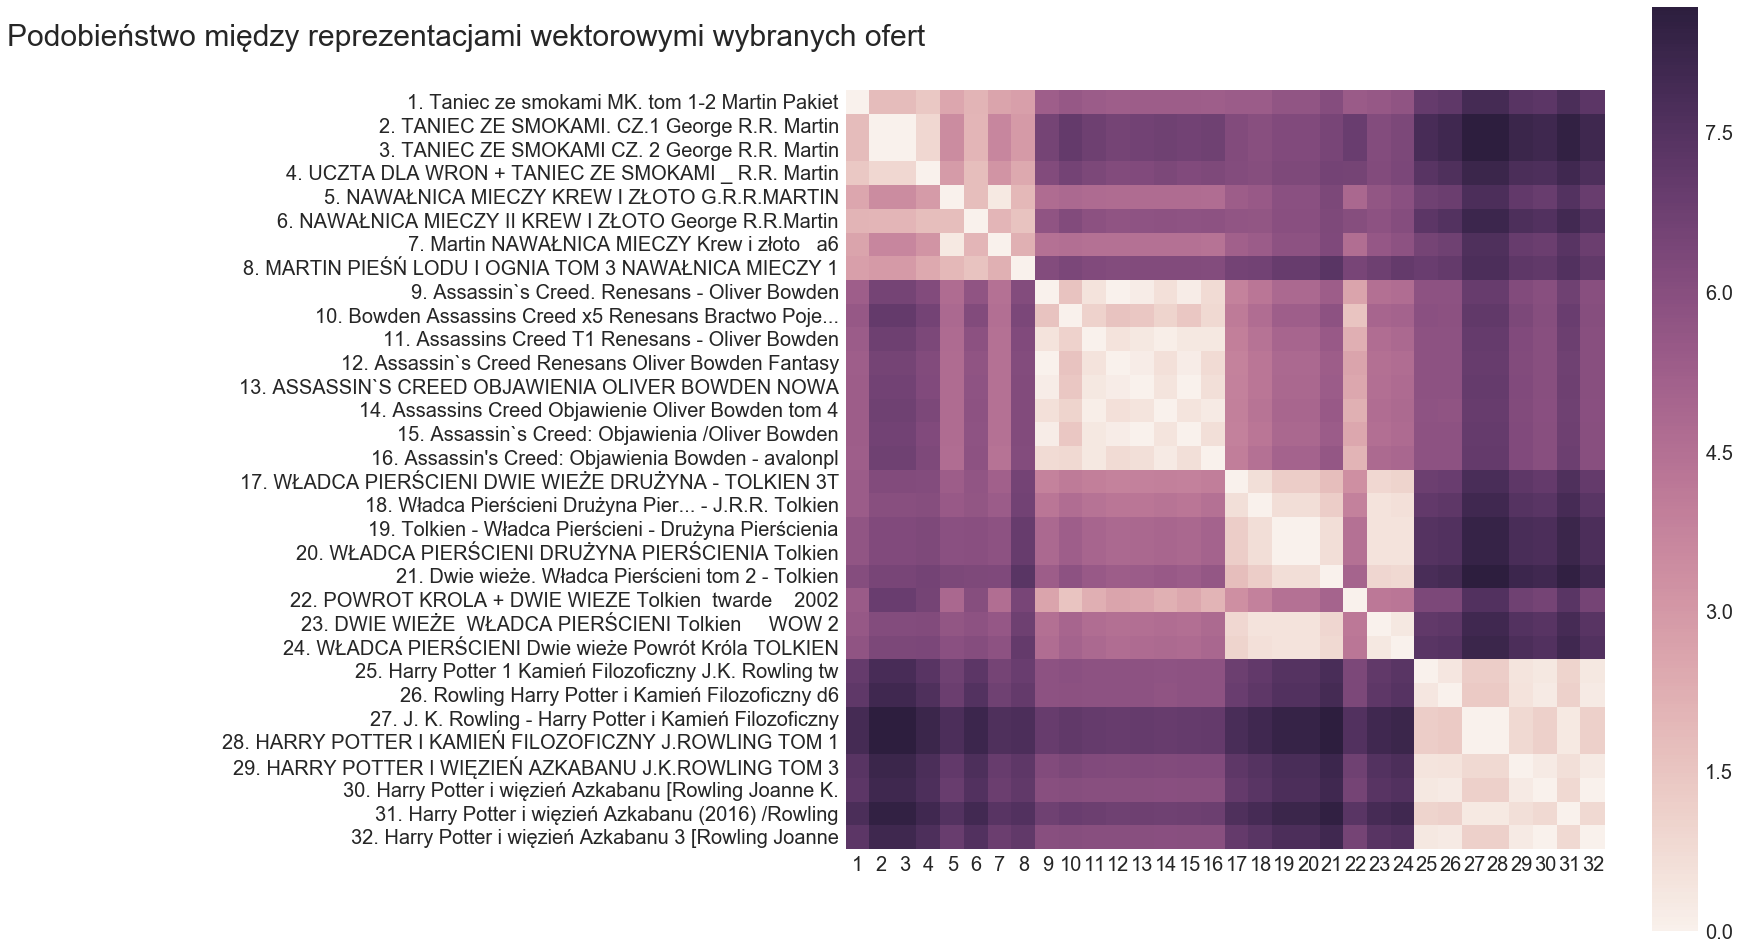

In [241]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(17,17))
ax.set_title('Podobieństwo między reprezentacjami wektorowymi wybranych ofert')
ax.title.set_size(30)
ax.title.set_position([-0.5, 1.05])
seaborn.set(font_scale = 2)
plt = seaborn.heatmap(similarity_matrix, ax=ax, square=True)
seaborn.plt.show()